In [1]:
from xaitk_saliency.interfaces.perturb_image import PerturbImage
from xaitk_saliency.interfaces.vis_sal_classifier import ImageClassifierSaliencyMapGenerator
from smqtk_core.configuration import from_config_dict

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import torchvision.models as models
from sklearn.svm import SVC
import torch

sld_w_cfg = {
    "type": "xaitk_saliency.impls.saliency.sliding_window.SlidingWindow",
    "xaitk_saliency.impls.saliency.sliding_window.SlidingWindow": {
    "window_size": 25,
    "stride": 5,
    },
  }
fsal_w_cfg = {
    "type": "xaitk_saliency.impls.saliency.fsal.Fsal",
    "xaitk_saliency.impls.saliency.fsal.Fsal": {
    },
  }
slid_algo = from_config_dict(sld_w_cfg, PerturbImage.get_impls())
fsal_alg = from_config_dict(fsal_w_cfg, ImageClassifierSaliencyMapGenerator.get_impls())

/home/local/KHQ/bhavan.vasu/anaconda3/envs/xaitk_saliency/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
Failed to import caffe module: No module named 'caffe'


In [2]:
oldmodel = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*(list(oldmodel.children())[:-1]))
model = model.eval()
model = model.cuda()

imsize = 224
loader = transforms.Compose([transforms.Scale((imsize)), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    try:
        image = Image.open(image_name)
    except:
        image = image_name
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    return image.cuda().unsqueeze(0)

pos_feat = model(image_loader('dog.jpg')).cpu().detach().numpy().squeeze()
neg_feat = model(image_loader('horse.jpeg')).cpu().detach().numpy().squeeze()

test_img = Image.open('catdog.png')
test_feat = model(image_loader('catdog.png')).cpu().detach().numpy().squeeze()

pert_img, pertmask = slid_algo.perturb(test_img)
ptrbed_feat = [model(image_loader(ptrbed)).cpu().detach().numpy().squeeze() for ptrbed in pert_img]

/home/local/KHQ/bhavan.vasu/anaconda3/envs/xaitk_saliency/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [3]:
clf = SVC(random_state=0, tol=1e-5, probability=True)

clf.fit([pos_feat, neg_feat], [1, 0])
prtbd_conf = clf.predict_proba(ptrbed_feat)

dims = len(test_feat)
org_conf = clf.predict_proba(test_feat.reshape(1, dims))

final_saliency_map = fsal_alg.generate(org_conf[0], prtbd_conf, pertmask[:,:,:,0])


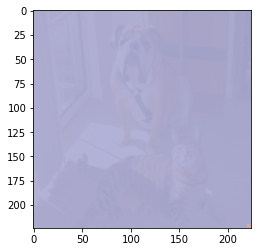

In [4]:
plt.figure()
plt.imshow(test_img, alpha=0.1)
plt.imshow(final_saliency_map[1], cmap='jet', alpha=0.3)
plt.show()